# 第03课：特征工程与技术指标

本课程将演示量化交易中特征工程的完整流程，包括技术指标计算、特征标准化、标签构建和信息系数(IC)分析。


## 1. 导入库与数据下载

**目的**：下载AAPL完整OHLCV数据，为技术指标计算提供基础数据源。

**金融含义**：OHLCV数据包含开盘、最高、最低、收盘价和成交量，是技术分析的基础。这些信息反映了市场参与者的交易行为和价格发现过程。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os
from datetime import datetime

# 尝试导入pandas_ta，如果没有则手工实现
try:
    import pandas_ta as ta
    HAS_PANDAS_TA = True
except ImportError:
    HAS_PANDAS_TA = False
    print("pandas_ta未安装，将使用向量化手工实现")

# 设置显示格式
pd.options.display.float_format = '{:.4f}'.format
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("库导入完成")


pandas_ta未安装，将使用向量化手工实现
库导入完成


In [5]:
# 下载AAPL OHLCV数据
try:
    data = yf.download('AAPL', start='2015-01-01', end=datetime.now().strftime('%Y-%m-%d'), auto_adjust=True)
    
    # 保留必要列
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    
    # 定义基础变量
    px = data['Close']
    ret = px.pct_change().fillna(0)
    
    print(f"数据下载成功，共{len(data)}个交易日")
    print(f"数据范围：{data.index[0].strftime('%Y-%m-%d')} 至 {data.index[-1].strftime('%Y-%m-%d')}")
    print(f"价格范围：${px.min():.2f} - ${px.max():.2f}")
    
except Exception as e:
    print(f"数据下载失败：{e}")
    print("请检查网络连接后重试")


[*********************100%***********************]  1 of 1 completed

数据下载成功，共2686个交易日
数据范围：2015-01-02 至 2025-09-08
价格范围：$20.62 - $258.10


## 2. 趋势指标计算

**目的**：计算移动平均线和指数平均线，捕捉价格趋势方向和强度。

**金融含义**：移动平均线是技术分析的核心工具，用于平滑价格波动并识别趋势。短期均线与长期均线的关系可以反映市场动量的变化，是构建交易信号的重要基础。


In [10]:
# 计算移动平均线
sma10 = px.rolling(10).mean()
sma50 = px.rolling(50).mean()
ema20 = px.ewm(span=20, adjust=False).mean()

print("趋势指标计算完成：")
print(f"SMA10: {sma10.dropna().iloc[:10].values}")
print(f"SMA50: {sma50.dropna().iloc[:3].values}")
print(f"EMA20: {ema20.dropna().iloc[:3].values}")

趋势指标计算完成：
SMA10: [[24.17849808]
 [24.10438175]
 [24.15919247]
 [24.23219948]
 [24.33538551]
 [24.35957355]
 [24.38376122]
 [24.38132   ]
 [24.49427052]
 [24.69620571]]
SMA50: [[26.61277222]
 [26.69359673]
 [26.7944622 ]]
EMA20: [[24.26104736]
 [24.19595482]
 [24.1372732 ]]


## 3. 布林带指标计算

**目的**：计算布林带上轨、中轨、下轨，衡量价格的相对位置和波动性。

**金融含义**：布林带基于价格的标准差构建动态支撑阻力位。当价格接近上轨时可能超买，接近下轨时可能超卖。布林带的宽窄反映市场波动性的高低。


In [11]:
# 计算布林带(20日，2倍标准差)
bb_mid = px.rolling(20).mean()
bb_std = px.rolling(20).std(ddof=0)
bb_up = bb_mid + 2 * bb_std
bb_dn = bb_mid - 2 * bb_std

print("布林带指标计算完成：")
print(f"BB_MID: {bb_mid.dropna().iloc[:3].values}")
print(f"BB_UP: {bb_up.dropna().iloc[:3].values}")
print(f"BB_DN: {bb_dn.dropna().iloc[:3].values}")


布林带指标计算完成：
BB_MID: [[24.55207777]
 [24.65526438]
 [24.79284601]]
BB_UP: [[26.10634058]
 [26.38289209]
 [26.59204523]]
BB_DN: [[22.99781496]
 [22.92763666]
 [22.9936468 ]]


## 4. RSI指标计算

**目的**：计算14日相对强弱指标，衡量价格动量的强弱程度。

**金融含义**：RSI通过比较一定期间内的涨跌幅度来判断价格走势的强弱。RSI > 70通常被认为超买，RSI < 30被认为超卖，是判断价格反转时机的重要指标。


In [19]:
# 计算RSI(14)
def calc_rsi(prices, period=14):
    """手工实现RSI计算"""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

if HAS_PANDAS_TA:
    rsi14 = ta.rsi(px, length=14)
else:
    rsi14 = calc_rsi(px, 14)

print("RSI指标计算完成：")
print(f"RSI14范围: {rsi14.dropna().values.min():.2f} - {rsi14.dropna().values.max():.2f}")
print(f"RSI14前3值: {rsi14.dropna().iloc[:3].values}")


RSI指标计算完成：
RSI14范围: 3.18 - 96.16
RSI14前3值: [[56.6135062 ]
 [57.67128707]
 [66.44264451]]


## 5. ATR和波动率指标计算

**目的**：计算平均真实范围(ATR)和收益率波动性，衡量市场波动程度。

**金融含义**：ATR反映价格的真实波动幅度，考虑了跳空因素。高ATR表示市场波动加剧，低ATR表示市场相对平静。波动率是风险管理和仓位调整的重要参考。


In [32]:
px

Ticker,AAPL
Date,
2015-01-02,24.2610
2015-01-05,23.5776
2015-01-06,23.5798
2015-01-07,23.9104
2015-01-08,24.8291
...,...
2025-09-02,229.7200
2025-09-03,238.4700
2025-09-04,239.7800


In [38]:
# 计算ATR(14)
high = data['High']
low = data['Low']
prev_close = px.shift(1)

tr1 = high - low
tr2 = abs(high - prev_close)
tr3 = abs(low - prev_close)

true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
atr14 = true_range.rolling(14).mean()
atr_pct = atr14 / px['AAPL']  # ATR百分比

# 计算20日年化波动率
vol20 = ret.rolling(20).std(ddof=0) * np.sqrt(252)

print("波动性指标计算完成：")
print(f"ATR14: {atr14.dropna().iloc[:3].values}")
print(f"ATR%: {atr_pct.dropna().iloc[:3].values}")
print(f"VOL20: {vol20.dropna().iloc[:3].values}")


波动性指标计算完成：
ATR14: [0.70328394 0.67364351 0.63623647]
ATR%: [0.02819644 0.02686943 0.02535045]
VOL20: [[0.36749619]
 [0.36845411]
 [0.34948669]]


## 6. 特征工程与构造

**目的**：基于技术指标构造可学习的特征，包括动量、相对强度、位置等。

**金融含义**：将原始指标转换为标准化的特征有助于机器学习模型更好地识别模式。这些特征捕捉了价格的趋势、动量、相对位置等不同维度的市场信息。


In [40]:
# 构造特征
features = pd.DataFrame(index=px.index)

# 动量特征
features['mom10'] = px.pct_change(10)  # 10日动量
features['ret1'] = ret  # 当期收益

# 均线相对强度
features['ma_ratio'] = sma10 / sma50 - 1  # 短长均线比值

# 布林带位置
features['bb_pos'] = (px - bb_mid) / (2 * bb_std)  # 布林带相对位置

# RSI标准化 
features['rsi_norm'] = (rsi14 - 50) / 50  # RSI中性化

# 波动率特征（确保为Series后赋值）
features['atr_pct'] = getattr(atr_pct, 'squeeze', lambda: atr_pct)()
features['vol20'] = getattr(vol20, 'squeeze', lambda: vol20)()

print("特征构造完成：")
print(f"特征数量: {len(features.columns)}")
print(f"特征列名: {list(features.columns)}")
print(f"样本数量: {len(features)}")


特征构造完成：
特征数量: 7
特征列名: ['mom10', 'ret1', 'ma_ratio', 'bb_pos', 'rsi_norm', 'atr_pct', 'vol20']
样本数量: 2686


## 7. 滚动标准化处理

**目的**：对特征进行滚动Z-score标准化，避免使用未来信息进行标准化。

**金融含义**：滚动标准化确保每个时点的标准化只使用历史信息，避免前视偏差。这种处理方式更接近真实交易环境，保证模型的实用性。


In [41]:
# 滚动标准化(252日)
X = pd.DataFrame(index=features.index)

for col in features.columns:
    # 滚动均值和标准差(避免未来信息)
    mean_roll = features[col].rolling(252).mean().shift(1)
    std_roll = features[col].rolling(252).std(ddof=0).shift(1)
    
    # Z-score标准化
    X[col] = (features[col] - mean_roll) / std_roll

# 去除缺失值
X = X.dropna()

print("滚动标准化完成：")
print(f"标准化后样本数: {len(X)}")
print(f"数据范围: {X.index[0]} 至 {X.index[-1]}")
print("\n前5行数据:")
print(X.head())


滚动标准化完成：
标准化后样本数: 2385
数据范围: 2016-03-15 00:00:00 至 2025-09-08 00:00:00

前5行数据:
            mom10    ret1  ma_ratio  bb_pos  rsi_norm  atr_pct   vol20
Date                                                                  
2016-03-15 1.1104  1.1926    1.4249  1.6311    2.6890  -0.7396 -0.5038
2016-03-16 1.3723  0.7954    1.5513  1.7247    2.7105  -0.7463 -0.5188
2016-03-17 1.1400 -0.0640    1.6391  1.4848    2.5717  -0.7332 -0.7052
2016-03-18 0.8037  0.0973    1.6787  1.3615    2.6360  -0.7575 -0.7180
2016-03-21 1.0670  0.0242    1.7225  1.2272    2.1370  -0.8948 -0.7134


## 8. 标签创建与数据对齐

**目的**：创建回归和分类标签，确保特征与标签正确对齐，避免前视偏差。

**金融含义**：标签设计是监督学习的核心。回归标签预测具体的收益率，分类标签预测涨跌方向。正确的时间对齐确保用t期特征预测t+1期结果，符合实际交易逻辑。


In [47]:
# 创建标签
y_reg = ret.shift(-1)  # 下一期收益(回归标签)
y_cls = (y_reg > 0).astype(int)  # 下一期方向(分类标签)

# 与特征对齐
aligned_data = pd.concat([X, y_reg['AAPL'].rename('y_reg'), y_cls['AAPL'].rename('y_cls')], axis=1).dropna()

# 分离特征和标签
X_final = aligned_data[X.columns]
y_reg_final = aligned_data['y_reg']
y_cls_final = aligned_data['y_cls']

print("标签创建与对齐完成：")
print(f"最终样本数: {len(aligned_data)}")
print(f"特征维度: {X_final.shape}")
print(f"正收益比例: {y_cls_final.mean():.3f}")
print(f"收益率统计: 均值={y_reg_final.mean():.4f}, 标准差={y_reg_final.std():.4f}")

print("\n数据对齐检查:")
print(f"特征索引范围: {X_final.index[0]} 至 {X_final.index[-1]}")
print(f"标签索引范围: {y_reg_final.index[0]} 至 {y_reg_final.index[-1]}")
print(f"索引对齐检查: {(X_final.index == y_reg_final.index).all()}")


标签创建与对齐完成：
最终样本数: 2384
特征维度: (2384, 7)
正收益比例: 0.535
收益率统计: 均值=0.0011, 标准差=0.0184

数据对齐检查:
特征索引范围: 2016-03-15 00:00:00 至 2025-09-05 00:00:00
标签索引范围: 2016-03-15 00:00:00 至 2025-09-05 00:00:00
索引对齐检查: True


## 9. 信息系数(IC)分析

**目的**：计算各特征与未来收益的秩相关系数，评估特征的预测能力。

**金融含义**：IC衡量特征排序与收益排序的一致性。高IC表示特征具有良好的预测能力。在日频数据中，IC通常较低但稳定的IC比偶然的高IC更有价值。


In [48]:
# 计算特征IC(Spearman秩相关)
ic_scores = {}

for col in X_final.columns:
    ic = X_final[col].rank(pct=True).corr(y_reg_final.rank(pct=True))
    ic_scores[col] = ic

# 转换为DataFrame并排序
ic_df = pd.DataFrame(list(ic_scores.items()), columns=['Feature', 'IC']).sort_values('IC', key=abs, ascending=False)

print("信息系数(IC)分析结果：")
print(ic_df.round(4))

print(f"\n最高IC特征: {ic_df.iloc[0]['Feature']} (IC={ic_df.iloc[0]['IC']:.4f})")
print(f"最低IC特征: {ic_df.iloc[-1]['Feature']} (IC={ic_df.iloc[-1]['IC']:.4f})")
print(f"平均绝对IC: {ic_df['IC'].abs().mean():.4f}")


信息系数(IC)分析结果：
    Feature      IC
0     mom10  0.0233
3    bb_pos  0.0214
4  rsi_norm  0.0149
5   atr_pct -0.0119
2  ma_ratio -0.0064
6     vol20 -0.0051
1      ret1  0.0047

最高IC特征: mom10 (IC=0.0233)
最低IC特征: ret1 (IC=0.0047)
平均绝对IC: 0.0125


## 10. 价格与均线可视化

**目的**：绘制价格与移动平均线的关系图，展示趋势指标的表现。

**金融含义**：价格与均线的关系直观反映趋势状态。价格在均线之上通常表示上升趋势，反之表示下降趋势。不同周期均线的交叉是经典的技术分析信号。


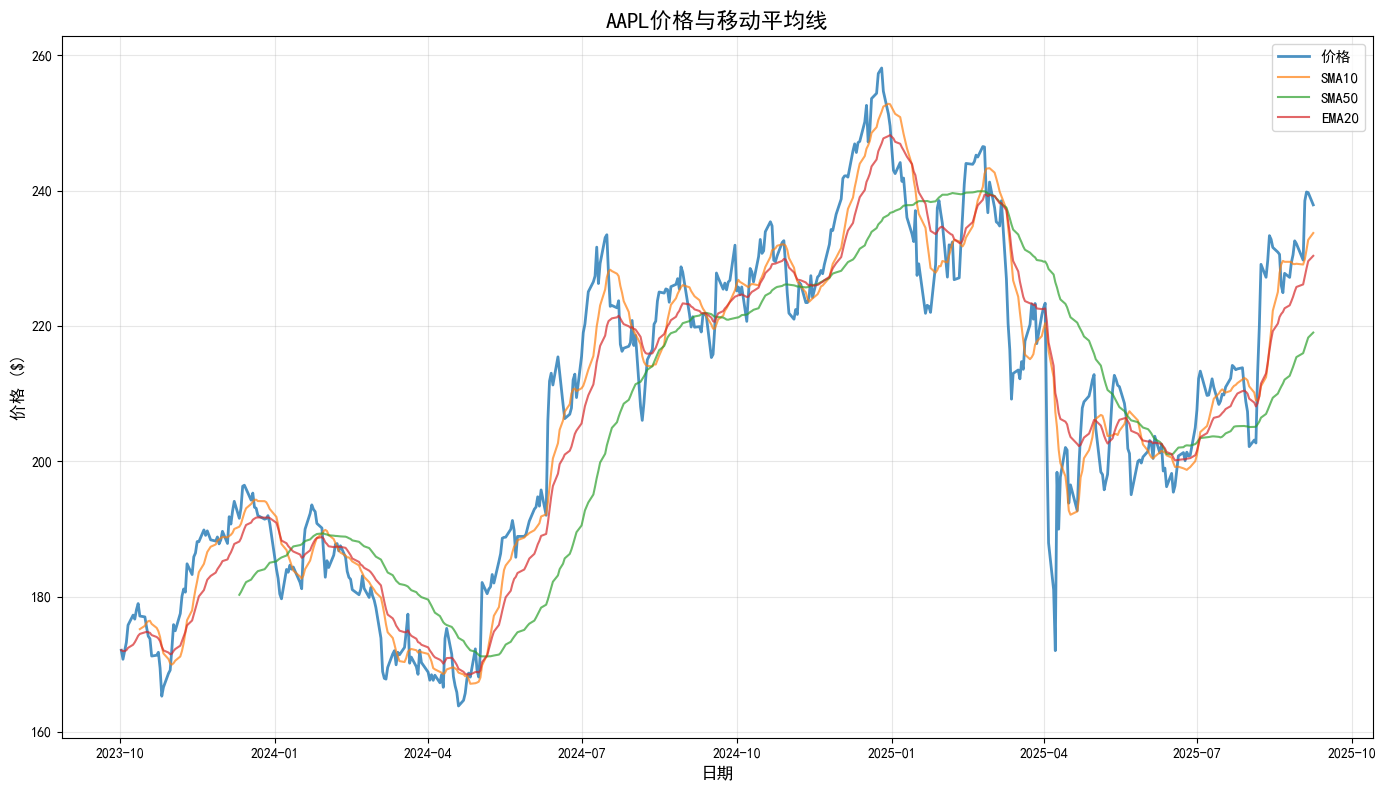

In [49]:
# 绘制价格与均线图
plt.figure(figsize=(14, 8))

# 选择最近2年数据进行展示
recent_data = data.last('24M')
recent_px = recent_data['Close']
recent_sma10 = recent_px.rolling(10).mean()
recent_sma50 = recent_px.rolling(50).mean()
recent_ema20 = recent_px.ewm(span=20, adjust=False).mean()

plt.plot(recent_px.index, recent_px.values, label='价格', linewidth=2, alpha=0.8)
plt.plot(recent_sma10.index, recent_sma10.values, label='SMA10', linewidth=1.5, alpha=0.7)
plt.plot(recent_sma50.index, recent_sma50.values, label='SMA50', linewidth=1.5, alpha=0.7)
plt.plot(recent_ema20.index, recent_ema20.values, label='EMA20', linewidth=1.5, alpha=0.7)

plt.title('AAPL价格与移动平均线', fontsize=16, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('价格 ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 11. 布林带可视化

**目的**：绘制布林带与价格的关系，展示价格的相对位置和波动边界。

**金融含义**：布林带提供了动态的支撑阻力位。当价格触及上轨时往往面临阻力，触及下轨时往往获得支撑。布林带的收缩和扩张反映了市场波动性的变化。


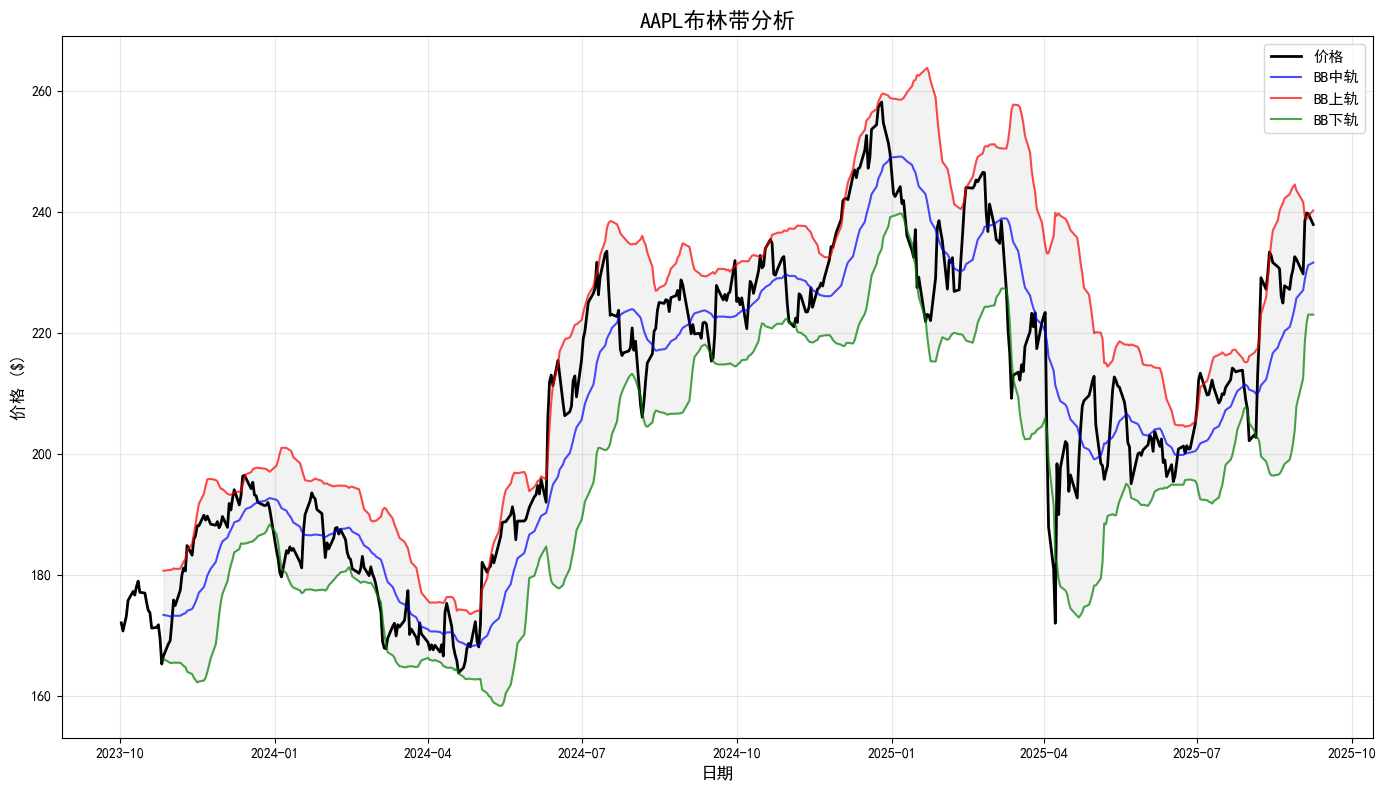

In [53]:
# 绘制布林带图
plt.figure(figsize=(14, 8))

# 计算最近数据的布林带
recent_bb_mid = recent_px.rolling(20).mean()
recent_bb_std = recent_px.rolling(20).std(ddof=0)
recent_bb_up = recent_bb_mid + 2 * recent_bb_std
recent_bb_dn = recent_bb_mid - 2 * recent_bb_std


plt.plot(recent_px.index, recent_px.values, label='价格', linewidth=2, color='black')
plt.plot(recent_bb_mid.index, recent_bb_mid['AAPL'].values, label='BB中轨', linewidth=1.5, color='blue', alpha=0.7)
plt.plot(recent_bb_up.index, recent_bb_up['AAPL'].values, label='BB上轨', linewidth=1.5, color='red', alpha=0.7)
plt.plot(recent_bb_dn.index, recent_bb_dn['AAPL'].values, label='BB下轨', linewidth=1.5, color='green', alpha=0.7)

# 填充布林带区域
plt.fill_between(recent_bb_up.index, recent_bb_up['AAPL'].values, recent_bb_dn['AAPL'].values, alpha=0.1, color='gray')

plt.title('AAPL布林带分析', fontsize=16, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('价格 ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 12. RSI指标可视化

**目的**：绘制RSI指标的时间序列图，展示价格动量的强弱变化。

**金融含义**：RSI在0-100之间波动，70以上通常认为超买，30以下认为超卖。RSI的背离现象（价格创新高但RSI未创新高）往往预示着趋势可能反转。


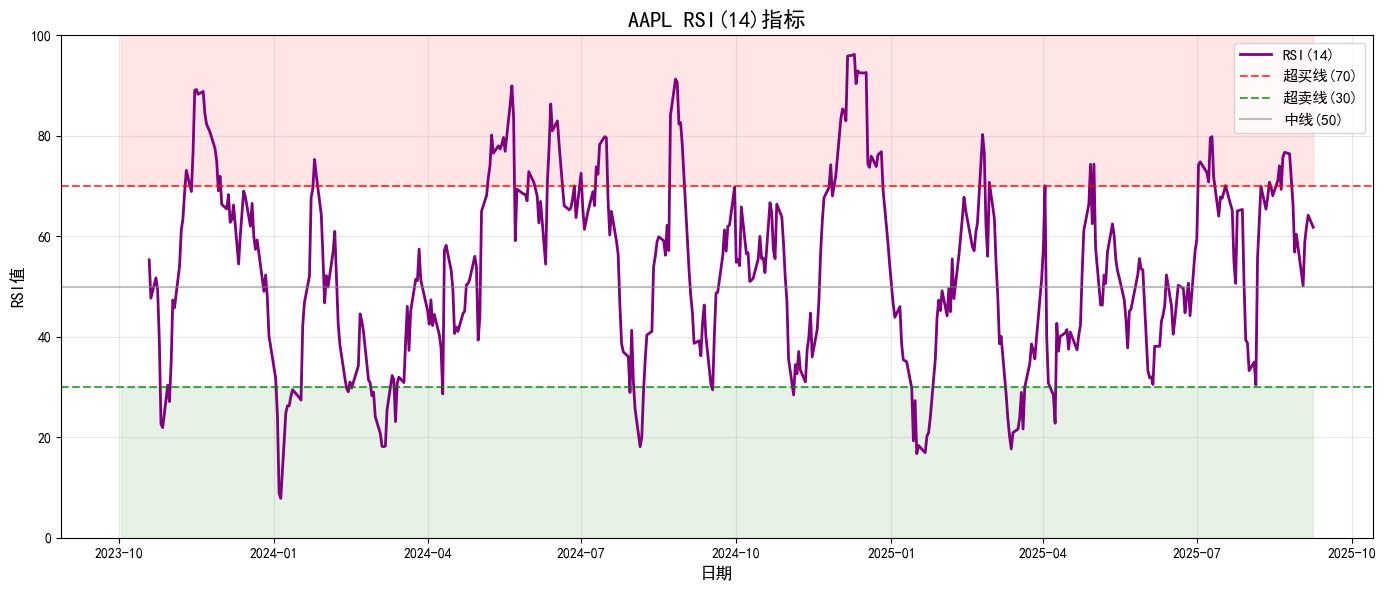

In [54]:
# 绘制RSI指标图
plt.figure(figsize=(14, 6))

# 计算最近数据的RSI
if HAS_PANDAS_TA:
    recent_rsi = ta.rsi(recent_px, length=14)
else:
    recent_rsi = calc_rsi(recent_px, 14)

plt.plot(recent_rsi.index, recent_rsi.values, label='RSI(14)', linewidth=2, color='purple')

# 添加超买超卖线
plt.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='超买线(70)')
plt.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='超卖线(30)')
plt.axhline(y=50, color='gray', linestyle='-', alpha=0.5, label='中线(50)')

# 填充超买超卖区域
plt.fill_between(recent_rsi.index, 70, 100, alpha=0.1, color='red')
plt.fill_between(recent_rsi.index, 0, 30, alpha=0.1, color='green')

plt.title('AAPL RSI(14)指标', fontsize=16, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('RSI值', fontsize=12)
plt.ylim(0, 100)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 13. 特征IC条形图

**目的**：以条形图形式展示各特征的信息系数，直观比较特征的预测能力。

**金融含义**：IC条形图帮助识别最有价值的特征。正IC表示特征与收益正相关，负IC表示负相关。在实际应用中，稳定的中等IC往往比不稳定的高IC更有价值。


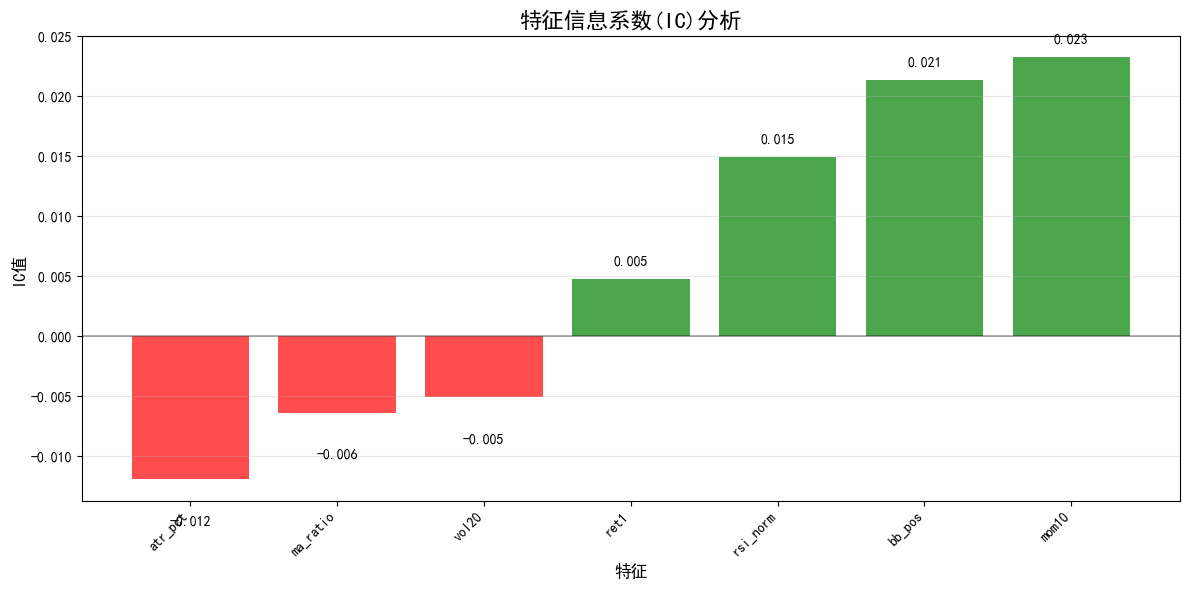


注意：IC在日频数据中通常较低，稳定性比单次数值更重要。


In [55]:
# 绘制IC条形图
plt.figure(figsize=(12, 6))

# 准备数据
features_sorted = ic_df.sort_values('IC')
colors = ['red' if x < 0 else 'green' for x in features_sorted['IC']]

bars = plt.bar(range(len(features_sorted)), features_sorted['IC'], color=colors, alpha=0.7)

# 添加数值标签
for i, (bar, ic) in enumerate(zip(bars, features_sorted['IC'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height >= 0 else -0.003),
             f'{ic:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=10, fontweight='bold')

plt.title('特征信息系数(IC)分析', fontsize=16, fontweight='bold')
plt.xlabel('特征', fontsize=12)
plt.ylabel('IC值', fontsize=12)
plt.xticks(range(len(features_sorted)), features_sorted['Feature'], rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n注意：IC在日频数据中通常较低，稳定性比单次数值更重要。")


## 14. 数据导出

**目的**：将处理好的特征和标签数据导出为parquet格式，供后续机器学习使用。

**金融含义**：标准化的数据导出确保数据的可重复使用性。parquet格式具有高效的压缩和快速读取特性，是量化研究中常用的数据存储格式。


In [57]:
pip install pyarrow

   ---------------------------------------- 0.0/25.2 MB ? eta -:--:--
   ------------ --------------------------- 7.9/25.2 MB 40.7 MB/s eta 0:00:01
   ----------------------- ---------------- 14.7/25.2 MB 37.0 MB/s eta 0:00:01
   -------------------------------- ------- 20.2/25.2 MB 33.6 MB/s eta 0:00:01
   ---------------------------------------- 25.2/25.2 MB 31.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [58]:
# 创建data目录（如果不存在）
if not os.path.exists('data'):
    os.makedirs('data')

# 导出数据
export_data = aligned_data.copy()
export_path = 'data/day3_features.parquet'

try:
    export_data.to_parquet(export_path)
    print(f"数据导出成功: {export_path}")
    print(f"导出数据形状: {export_data.shape}")
    print(f"导出列名: {list(export_data.columns)}")
    
    # 验证导出文件
    test_load = pd.read_parquet(export_path)
    print(f"验证加载成功: {test_load.shape}")
    
except Exception as e:
    print(f"数据导出失败: {e}")

print(f"\n最终数据统计:")
print(f"- 样本数量: {len(export_data)}")
print(f"- 特征数量: {len(X_final.columns)}")
print(f"- 时间范围: {export_data.index[0]} 至 {export_data.index[-1]}")
print(f"- 正收益样本比例: {export_data['y_cls'].mean():.3f}")


数据导出成功: data/day3_features.parquet
导出数据形状: (2384, 9)
导出列名: ['mom10', 'ret1', 'ma_ratio', 'bb_pos', 'rsi_norm', 'atr_pct', 'vol20', 'y_reg', 'y_cls']
验证加载成功: (2384, 9)

最终数据统计:
- 样本数量: 2384
- 特征数量: 7
- 时间范围: 2016-03-15 00:00:00 至 2025-09-05 00:00:00
- 正收益样本比例: 0.535


## 要点总结

### 技术指标的市场特征
- **趋势指标**(SMA/EMA)：反映价格方向和动量强度，是识别趋势的基础工具
- **布林带**：衡量价格相对位置和波动性，提供动态支撑阻力位
- **RSI**：量化价格动量强弱，识别超买超卖状态
- **ATR/波动率**：衡量市场风险水平，用于仓位管理和风险控制

### "特征在t预测t+1"的时间对齐
- 所有特征基于t期及之前信息构造，用于预测t+1期收益
- 标签使用`ret.shift(-1)`确保预测未来一期收益
- 严格避免前视偏差，保证实盘可用性

### 滚动标准化避免未来信息
- 使用252日滚动窗口进行Z-score标准化
- 关键：`shift(1)`确保标准化参数不使用当期信息
- 模拟真实交易环境中的特征处理流程

### IC的含义与用途
- 信息系数衡量特征排序与收益排序的一致性
- 日频IC通常在±0.05范围内，关注稳定性胜过绝对值
- IC分析帮助特征选择和组合优化

### 数据导出目的
- 标准化格式便于后续机器学习模型训练
- 包含完整特征矩阵和回归/分类标签
- 为Day 4-10的模型构建和策略开发提供数据基础
